In [5]:
#import packages
import csv
import pandas as pd
import random
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
from collections import defaultdict
import seaborn as sns
import json

In [6]:
# Generate map between subject code and school code
df = pd.read_csv("Course.csv")
df["School Code"] = df.Description.str.split(":").str.get(0)
df["Description"] = df.Description.str.split(":").str.get(1)
newdf = df.drop(columns=["Description"])
course_dict = newdf.set_index("Subject Code").to_dict()["School Code"]

In [7]:
# Generate map between subject code and department code
with open("subject_school_map.json") as f:
    subject_code = json.loads(f.read())

In [8]:
grade_dict = {'A+':4,'A':4,'A-':3.7,
             'B+':3.3,'B':3,'B-':2.7,
             'C+':2.3,'C':2,'C-':1.7,
             'D+':1.3,'D':1,'D-':0.7,
             'E':0}

In [9]:
grade_dict_reverse = {v: k for k, v in grade_dict.items()}
grade_dict_reverse[4]='A+/A'

In [10]:
#open data, add some iterator functions to make the process faster
undergrad_by_term = {}
def getrows():
    with open("larc_data_since_1210_all_new_with_all_sat.csv") as f:
        reader = csv.reader(f)
        next(reader)
        for row in reader:
            if row[15].isdigit():
                if int(row[15]) < 500:
                    if row[11] in grade_dict:
                        yield row

In [11]:
for row in getrows():
    if row[27] != '':
        row[19] = row[27]
    if row[4].split(' ')[1] in undergrad_by_term:
        undergrad_by_term[row[4].split(' ')[1]].append(row)
    else:
        undergrad_by_term[row[4].split(' ')[1]] = []
        undergrad_by_term[row[4].split(' ')[1]].append(row)

In [12]:
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
for year in years:
    for i, row in enumerate(undergrad_by_term[year]):
        try:
            row.append(course_dict[row[14]])
        except:
            del undergrad_by_term[year][i] # There are some subjects like "OPERA" which is not in the map, 
                                           # so I simply drop them

In [13]:
# Create dictionaries to store the filtered data.
LSA = defaultdict(list)
BA = defaultdict(list)
ENG = defaultdict(list)

for year in years:
    for row in undergrad_by_term[year]:
        if row[-1] == "LSA":
            LSA[year].append(row)
        elif row[-1] == "BA":
            BA[year].append(row)
        elif row[-1] == "ENG":
            ENG[year].append(row)

In [14]:
LSA_Human = defaultdict(list)
LSA_Lang = defaultdict(list)
LSA_NS = defaultdict(list)
LSA_SS = defaultdict(list)
LSA_subject = ['LSA Humanities', 'LSA Language','LSA Natural Science','LSA Other','LSA Social Science']
no_code_subject = set()
include_code_subject = set()
years = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018']
for year in years:
    for i, row in enumerate(LSA[year]):
        try:
            sub = subject_code[row[14]]
            row.append(sub)
            if sub == 'LSA Humanities':
                LSA_Human[year].append(row)
            elif sub == 'LSA Language':
                LSA_Lang[year].append(row)
            elif sub == 'LSA Natural Science':
                LSA_NS[year].append(row)
            elif sub == 'LSA Social Science':
                LSA_SS[year].append(row)
            include_code_subject.add(row[14])
        except:
            no_code_subject.add(row[14])

In [15]:
lv_1 = defaultdict(list)
lv_2 = defaultdict(list)
lv_3 = defaultdict(list)
lv_4 = defaultdict(list)
for year in years:
    for row in undergrad_by_term[year]:
        if int(row[15]) < 200:
            lv_1[year].append(row)
        elif int(row[15]) < 300:
            lv_2[year].append(row) 
        elif int(row[15]) < 400:
            lv_3[year].append(row) 
        else:
            lv_4[year].append(row)

In [16]:
lv_1_2 = defaultdict(list)
lv_3_4 = defaultdict(list)
for year in years:
    for row in undergrad_by_term[year]:
        if int(row[15]) < 300:
            lv_1_2[year].append(row)
        else:
            lv_3_4[year].append(row)

In [17]:
###2006 MAIN ALGO.

In [18]:
# Generate buckets
def generate_buckets(data):
    no_buckets = {}
    both_buckets = {}
    only_act = {}
    only_sat = {}
    no_buckets['2006'] = []
    both_buckets['2006'] = {}
    only_act['2006'] = {}
    only_sat['2006'] = {}
    
    for row in data['2006']:
        
        # no buckets
        if row[17] == '' and row[19] == '': # 17->act, 19->sat
            no_buckets['2006'].append(row)
            
        # only act
        elif row[17] != '' and row[19] == '':
            if row[17] in only_act['2006']:
                only_act['2006'][row[17]].append(row)
            else:
                only_act['2006'][row[17]] = []
                only_act['2006'][row[17]].append(row)
                
        # only sat
        elif row[17] == '' and row[19] != '':
            if row[19] in only_sat['2006']:
                only_sat['2006'][row[19]].append(row)
            else:
                only_sat['2006'][row[19]] = []
                only_sat['2006'][row[19]].append(row)
                
        # both buckets
        if row[17] in both_buckets['2006']:
            if row[19] in both_buckets['2006'][row[17]]:
                both_buckets['2006'][row[17]][row[19]].append(row)
            else:
                both_buckets['2006'][row[17]][row[19]] = []
                both_buckets['2006'][row[17]][row[19]].append(row)
        else:
            both_buckets['2006'][row[17]] = {}
            both_buckets['2006'][row[17]][row[19]] = []
            both_buckets['2006'][row[17]][row[19]].append(row)
            
    return no_buckets, both_buckets, only_act, only_sat

In [19]:
# Wrap up codes to serveral functions

# Input: dictionary DATA(filtered or unfiltered)
# Output: Tuple(dict, dict) (Data with generated samples, Debug data with propotion of no_buckets)

def generate_samples(data):
    no_buckets, both_buckets, only_act, only_sat = generate_buckets(data)
    df = []
    df.append(['year', 'type', 'value'])
    debug = defaultdict(list)
    for year in years:
        to_mean = []
        no_values = []
        both_values = []
        only_act_values=[]
        only_sat_values=[]
        count_no=0
        count_no_grad=0
        for row in data[year]:
            marked = False
            if row[17] != '' and row[19] != '': # to check act, sat exits
                marked = True
                if row[17] in both_buckets['2006']:
                    if row[19] in both_buckets['2006'][row[17]]:
                        to_mean.append(grade_dict[random.choice(both_buckets['2006'][row[17]][row[19]])[11]])
                        both_values.append(grade_dict[random.choice(both_buckets['2006'][row[17]][row[19]])[11]])
            if row[17] == '' and row[19] != '' and not marked:
                if row[19] in only_sat['2006']:
                    marked = True
                    to_mean.append(grade_dict[random.choice(only_sat['2006'][row[19]])[11]])
                    only_sat_values.append(grade_dict[random.choice(only_sat['2006'][row[19]])[11]])
            if row[17] != '' and row[19] == '' and not marked:
                if row[17] in only_act['2006']:
                    to_mean.append(grade_dict[random.choice(only_act['2006'][row[17]])[11]])
                    only_act_values.append(grade_dict[random.choice(only_act['2006'][row[17]])[11]])
            if row[17] == '' and row[19] == '' and not marked:
                to_mean.append(grade_dict[random.choice(no_buckets['2006'])[11]])
                no_values.append(grade_dict[random.choice(no_buckets['2006'])[11]])
                count_no+=1
                if row[5][0] != "U":
                    count_no_grad +=1
        df.append([year, 'proj_gpe', sum(to_mean) / len(to_mean)])
        
        debug["year"].append(year)
        debug["no_propotion"].append(count_no/len(to_mean))
        debug["grad_propotion"].append(count_no_grad/count_no)
        debug["no_average"].append(sum(no_values) / len(to_mean))
        debug["both_average"].append(sum(both_values) / len(to_mean))
        debug["only_sat_average"].append(sum(only_sat_values) / len(to_mean))
        debug["only_act_average"].append(sum(only_act_values) / len(to_mean))
        debug['size'].append(len(to_mean))
        
    for year in years:
        to_mean = []
        for row in data[year]:
            if row[17] != '':
                to_mean.append(float(row[17]))
        df.append([year, 'actual_act', (sum(to_mean) / len(to_mean)) /36 * 4])
    for year in years:
        to_mean = []
        for row in data[year]:
            if row[19] != '':
                to_mean.append(float(row[19]))
        df.append([year, 'actual_sat', (sum(to_mean) / len(to_mean)) /1600 * 4])
    for year in years:
        to_mean = []
        for row in data[year]:
            to_mean.append(grade_dict[row[11]])
        df.append([year, 'actual_gpe', sum(to_mean)/len(to_mean)])
    df = pd.DataFrame(df[1:], columns=df[0])
    debug = pd.DataFrame(debug, columns=['year', 'no_propotion', 'grad_propotion', 'no_average', 'both_average','only_sat_average','only_act_average', 'size'])
    return df, debug

In [20]:
# Make plots
def make_plot(df, title):
    fig, ax = plt.subplots(figsize=(15,7))
    plt.title(title + ' UNDERGRADUATE COURSES')
    new_df = df.groupby(['year','type']).sum()['value'].unstack()
    new_df.index = new_df.index.astype('int')
    new_df.plot(ax=ax, ylim=[3.0,3.6], xlim=[2005,2019], xticks=list(map(int, years)))

## Generate Mapping

## Results - 2006 Sampling

### University wide

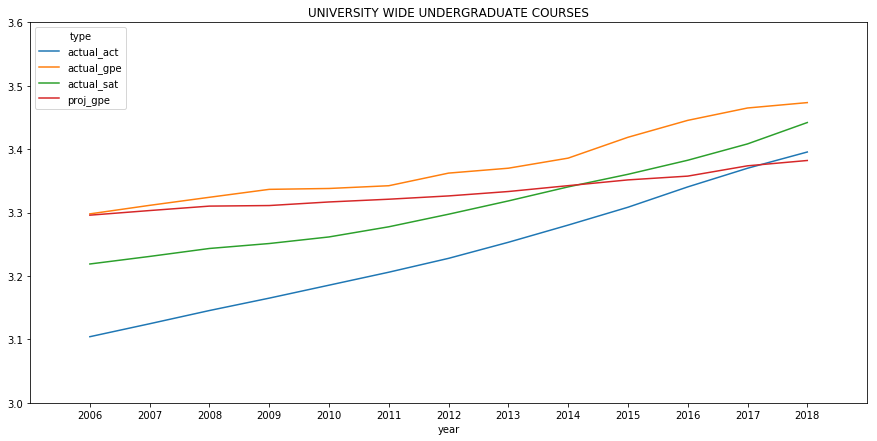

In [18]:
make_plot(generate_samples(undergrad_by_term)[0], "UNIVERSITY WIDE")

### Different Schools

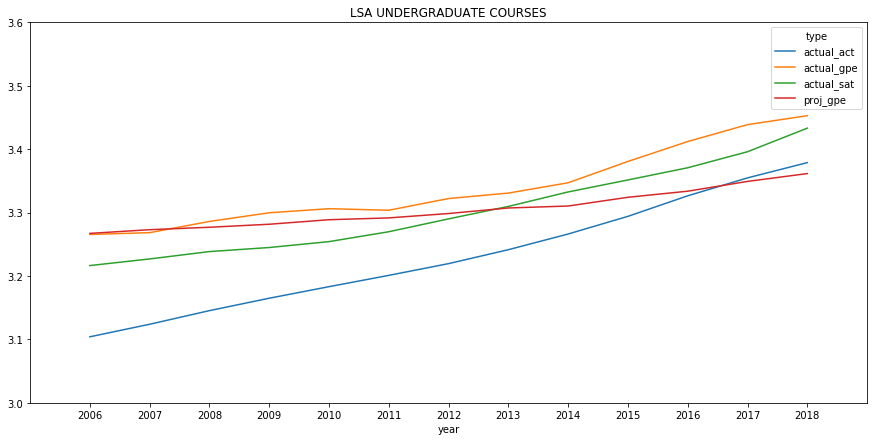

In [19]:
make_plot(generate_samples(LSA)[0], "LSA")

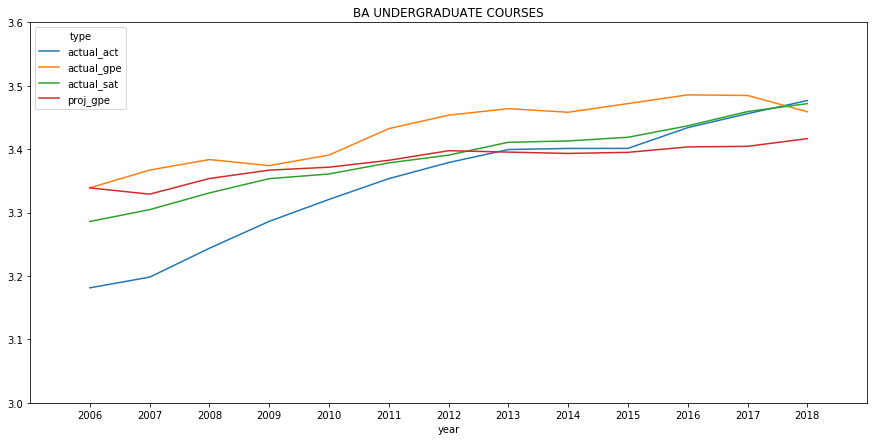

In [20]:
make_plot(generate_samples(BA)[0], "BA")

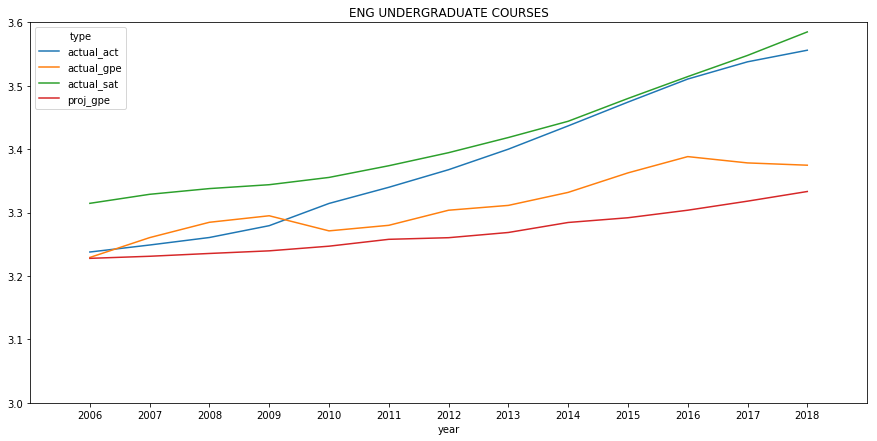

In [21]:
make_plot(generate_samples(ENG)[0], "ENG")

### Different level of courses

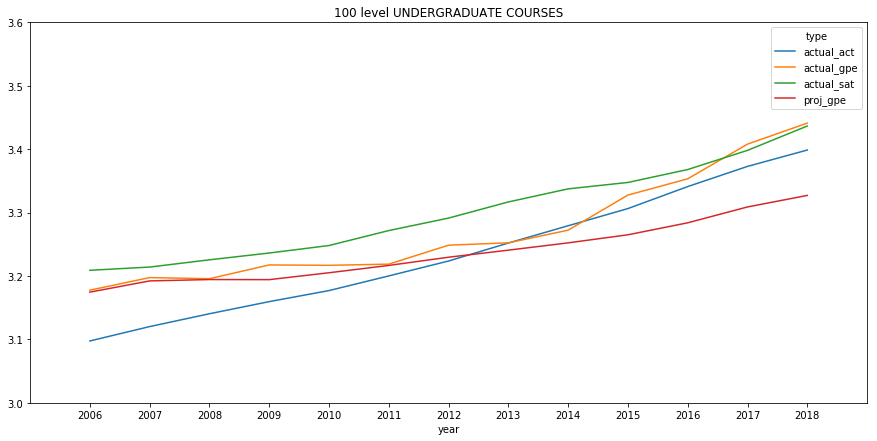

In [22]:
make_plot(generate_samples(lv_1)[0], "100 level")

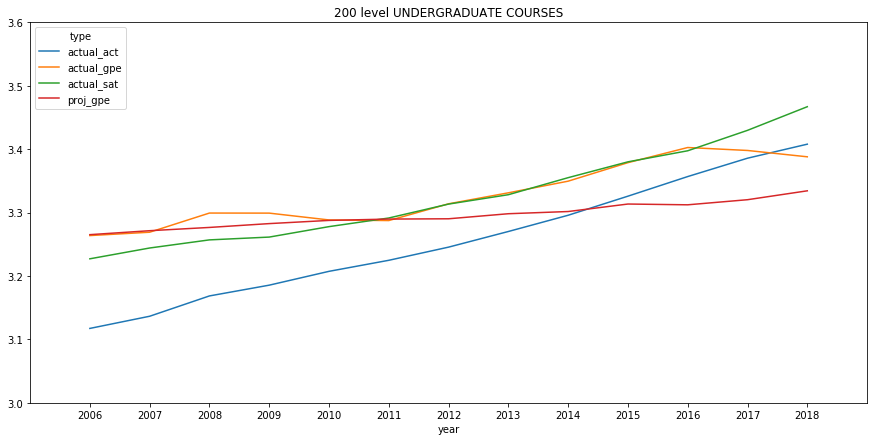

In [23]:
make_plot(generate_samples(lv_2)[0], "200 level")

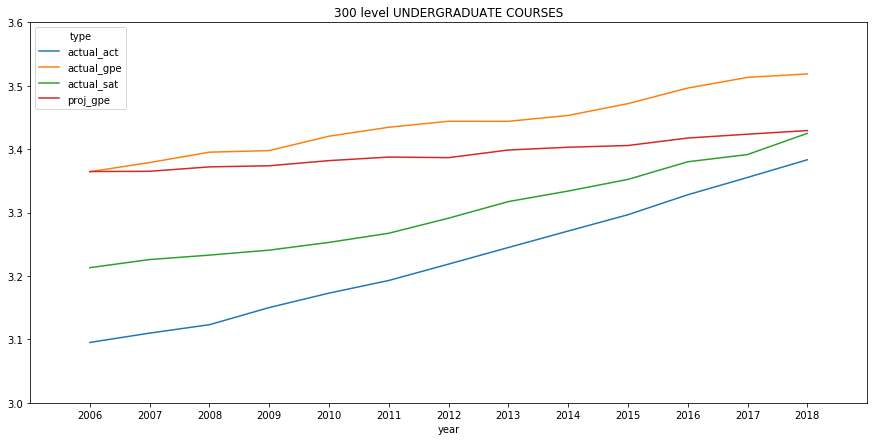

In [24]:
make_plot(generate_samples(lv_3)[0], "300 level")

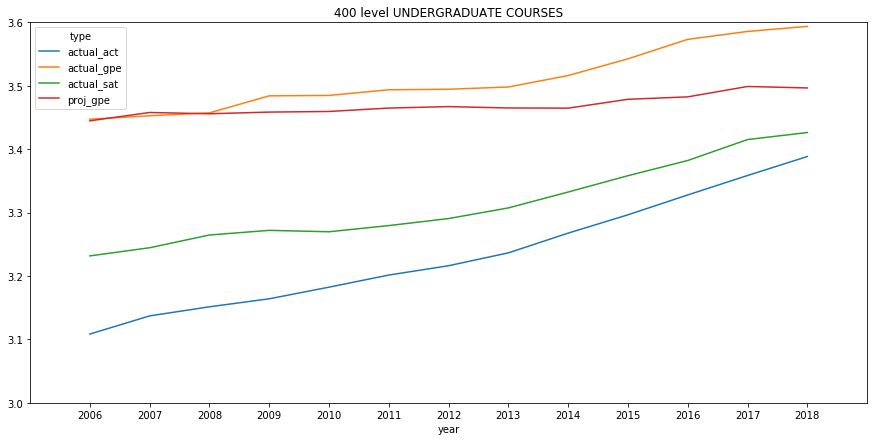

In [25]:
make_plot(generate_samples(lv_4)[0], "400 level")

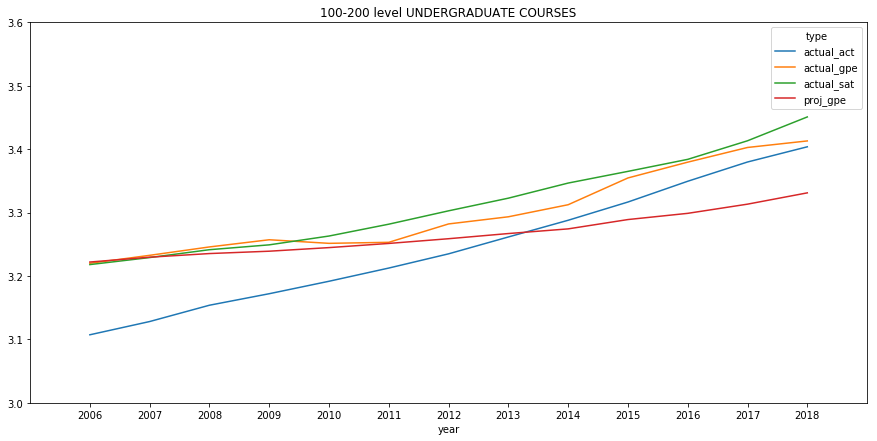

In [26]:
make_plot(generate_samples(lv_1_2)[0], "100-200 level")

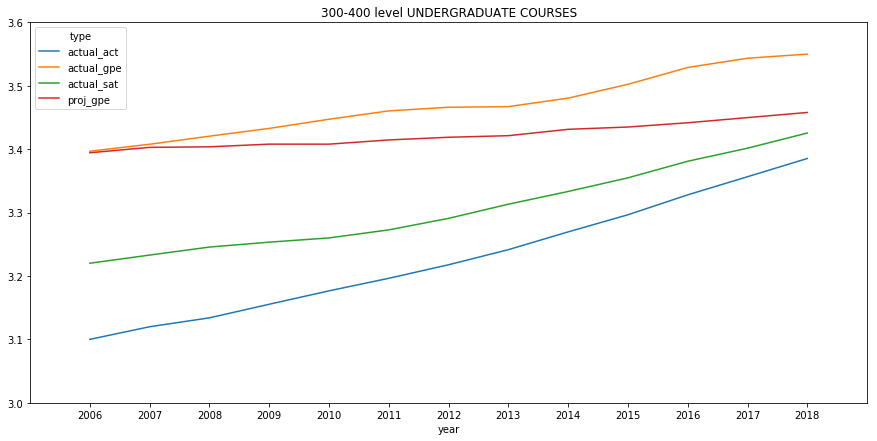

In [27]:
make_plot(generate_samples(lv_3_4)[0], "300-400 level")

### Different Subjects in LSA

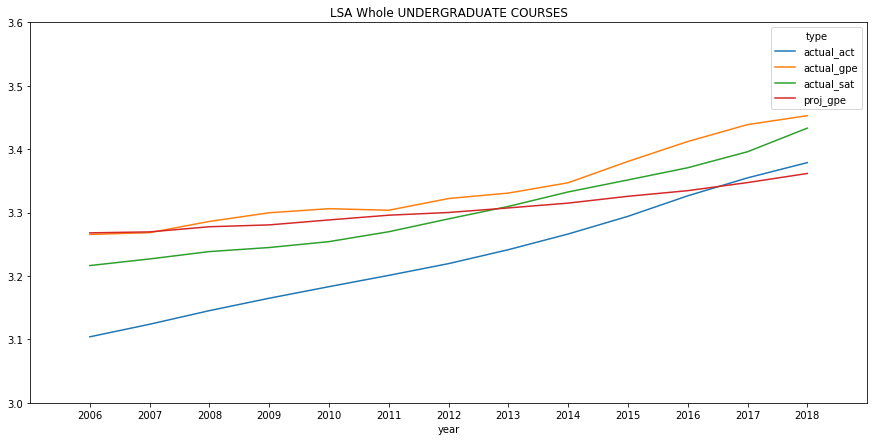

In [28]:
make_plot(generate_samples(LSA)[0], "LSA Whole")

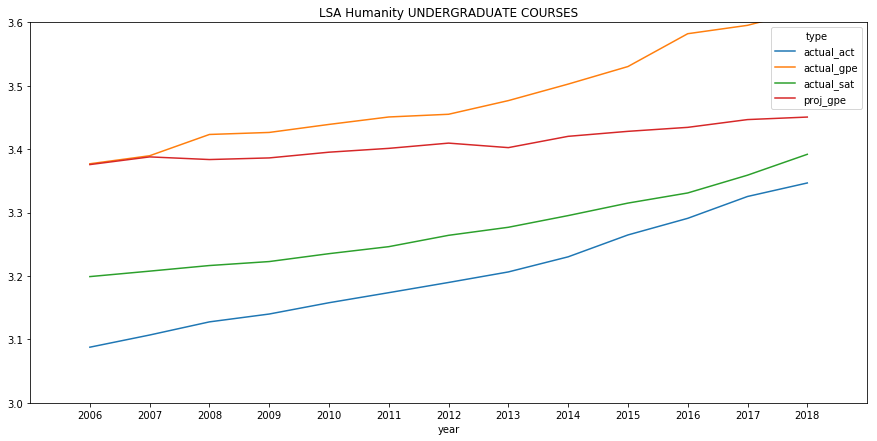

In [29]:
make_plot(generate_samples(LSA_Human)[0], "LSA Humanity")

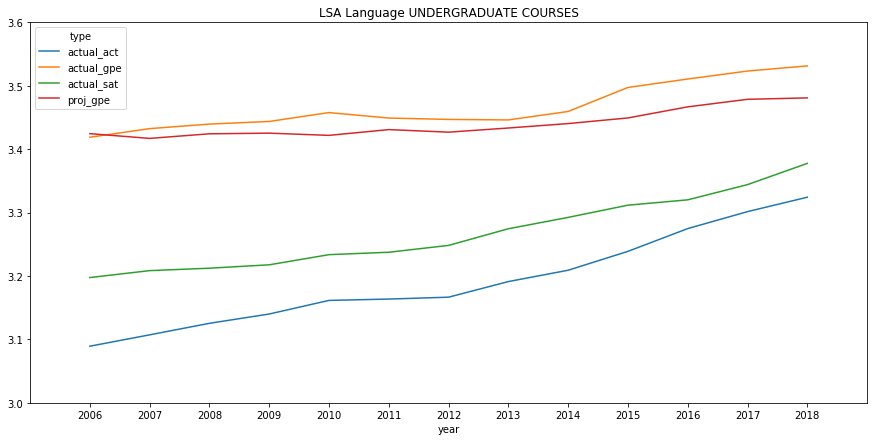

In [30]:
make_plot(generate_samples(LSA_Lang)[0], "LSA Language")

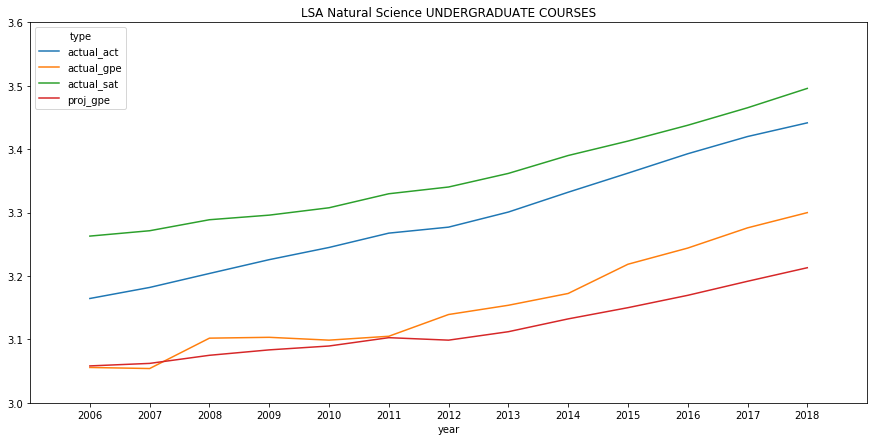

In [31]:
make_plot(generate_samples(LSA_NS)[0], "LSA Natural Science")

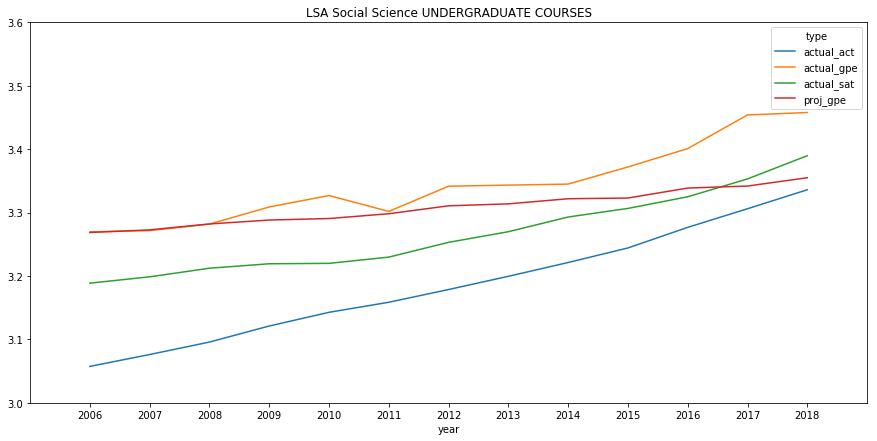

In [32]:
make_plot(generate_samples(LSA_SS)[0], "LSA Social Science")

In [33]:
def generate_course_df(level_df):
    lv_course = defaultdict(list)
    for year in years:
        for s in level_df[year]:
            lv_course['year'].append(year)
            lv_course['course'].append(s[14]+s[15])
            lv_course['GPA'].append(grade_dict[s[11]])
            lv_course['std_id'].append(s[0])
            if s[17] == '':
                lv_course['ACT'].append(float(0))
            else: 
                lv_course['ACT'].append(float(s[17]))
            if s[19] == '':
                lv_course['SAT'].append(float(0))
            else:
                lv_course['SAT'].append(float(s[19]))
    lv_course_df = pd.DataFrame(lv_course, 
                                 columns=['std_id', 'year', 'course', 'GPA', 'ACT', 'SAT'])
    return lv_course_df

In [34]:
LSA_Human_df = generate_course_df(LSA_Human)
LSA_Lang_df = generate_course_df(LSA_Lang)
LSA_NS_df = generate_course_df(LSA_NS)
LSA_SS_df = generate_course_df(LSA_SS)

In [35]:
def course_count(df):
    unique_course = []
    for year in years:
        unique_course.append(df[df['year']==year]['course'].nunique())
    return unique_course

In [36]:
def std_count(df):
    unique_std = []
    for year in years:
        unique_std.append(df[df['year']==year]['std_id'].nunique())
    return unique_std

In [37]:
std_sum_lst = []
df_lst = [LSA_Human_df, LSA_Lang_df, LSA_NS_df, LSA_SS_df]
for year in years:
    s = 0
    for df in df_lst:
        s += df[df['year']==year]['std_id'].nunique()
    std_sum_lst.append(s)

In [38]:
def std_propotion_count(df):
    unique_std = []
    for i, year in enumerate(years):
        unique_std.append(df[df['year']==year]['std_id'].nunique() / std_sum_lst[i])
    return unique_std

/Users/chenjieqing/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


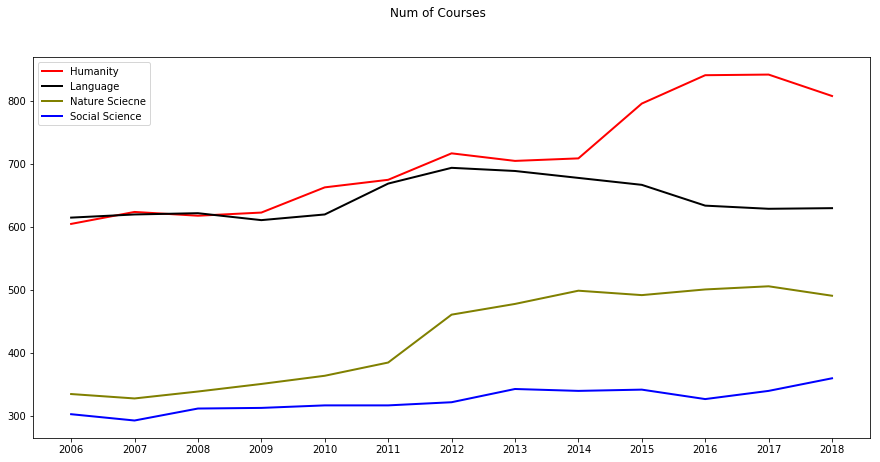

In [39]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot( years, course_count(LSA_Human_df), color='red', linewidth=2, label='Humanity')
plt.plot( years, course_count(LSA_Lang_df), marker='', color='black', linewidth=2,label="Language" )
plt.plot( years, course_count(LSA_NS_df), marker='', color='olive', linewidth=2, label='Nature Sciecne')
plt.plot( years, course_count(LSA_SS_df), marker='', color='blue', linewidth=2, label = 'Social Science')
plt.legend(loc='upper left')
fig.suptitle("Num of Courses")
fig.show()

/Users/chenjieqing/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


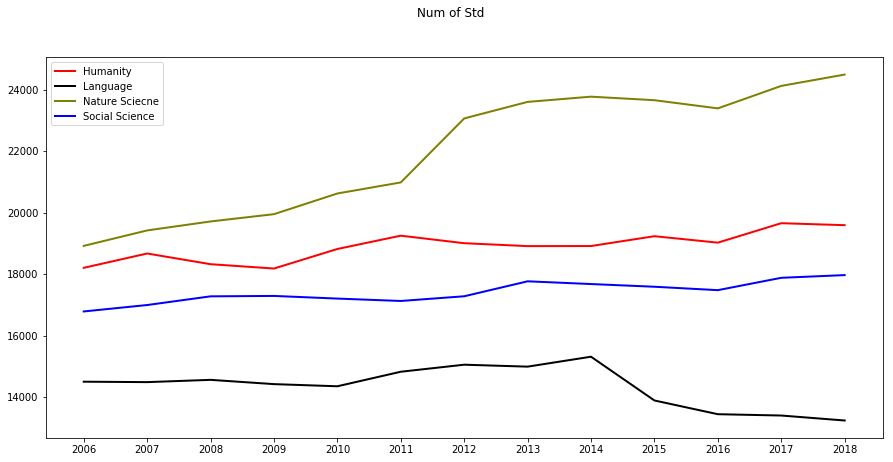

In [40]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot( years, std_count(LSA_Human_df), color='red', linewidth=2, label='Humanity')
plt.plot( years, std_count(LSA_Lang_df), marker='', color='black', linewidth=2,label="Language" )
plt.plot( years, std_count(LSA_NS_df), marker='', color='olive', linewidth=2, label='Nature Sciecne')
plt.plot( years, std_count(LSA_SS_df), marker='', color='blue', linewidth=2, label = 'Social Science')
fig.suptitle("Num of Std")
plt.legend(loc='upper left')
fig.show()

/Users/chenjieqing/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


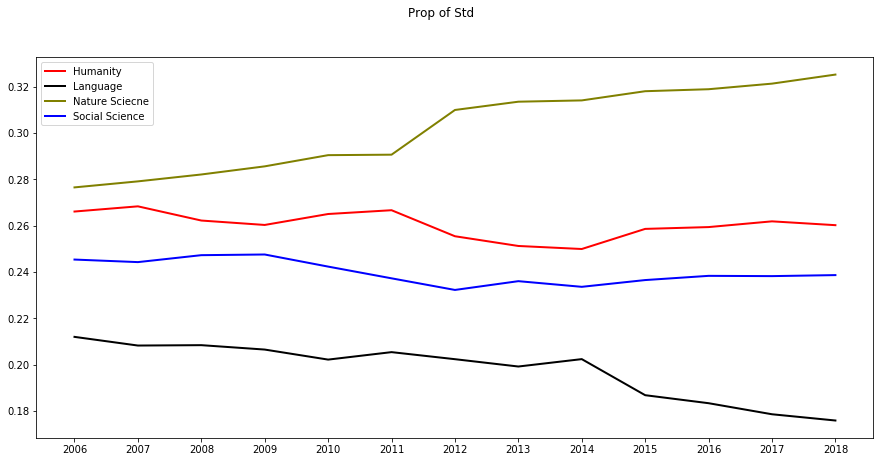

In [41]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot( years, std_propotion_count(LSA_Human_df), color='red', linewidth=2, label='Humanity')
plt.plot( years, std_propotion_count(LSA_Lang_df), marker='', color='black', linewidth=2,label="Language" )
plt.plot( years, std_propotion_count(LSA_NS_df), marker='', color='olive', linewidth=2, label='Nature Sciecne')
plt.plot( years, std_propotion_count(LSA_SS_df), marker='', color='blue', linewidth=2, label = 'Social Science')
fig.suptitle("Prop of Std")
plt.legend(loc='upper left')
fig.show()


In [42]:
LSA_Lang_df[LSA_Lang_df['year'].isin(['2014','2015'])].groupby('year').std_id.nunique()

year
2014    15310
2015    13886
Name: std_id, dtype: int64

In [43]:
temp1 = LSA_Human_df[LSA_Human_df['year']=='2014'].groupby('course').std_id.nunique().to_frame().reset_index()

In [44]:
temp2 = LSA_Human_df[LSA_Human_df['year']=='2015'].groupby('course').std_id.nunique().to_frame().reset_index()

In [45]:
temp_df = temp1.merge(temp2, how='outer', on='course' ).fillna(0)

In [46]:
temp_df['delta_num'] = temp_df["std_id_y"] - temp_df['std_id_x']

In [47]:
temp_df.set_index('course',inplace=True)

In [48]:
def reset_GPE(df):
    gpe_lst = []
    for value in df['GPA'].values:
        gpe_lst.append(grade_dict_reverse[value])
    df['GPE'] = gpe_lst
    return df

In [49]:
LSA_Human_df.head()

,std_id,year,course,GPA,ACT,SAT
0,302219,2006,ANTHRCUL374,2.7,27.0,1340.0
1,314343,2006,ANTHRCUL374,3.3,25.0,0.0
2,308239,2006,ANTHRCUL374,2.0,0.0,1320.0
3,306075,2006,ANTHRCUL374,4.0,0.0,1210.0
4,307923,2006,ANTHRCUL374,2.0,27.0,0.0


In [50]:
gpe_lst = list(grade_dict.keys())

In [51]:
gpe_lst.pop(0)

'A+'

In [52]:
gpe_lst[0] = 'A+/A'

In [53]:
gpe_lst.sort(reverse=True)

In [54]:
gpe_lst = ['E', 'D-', 'D', 'D+', 'C-', 'C', 'C+', 'B-', 'B', 'B+', 'A-', 'A+/A']

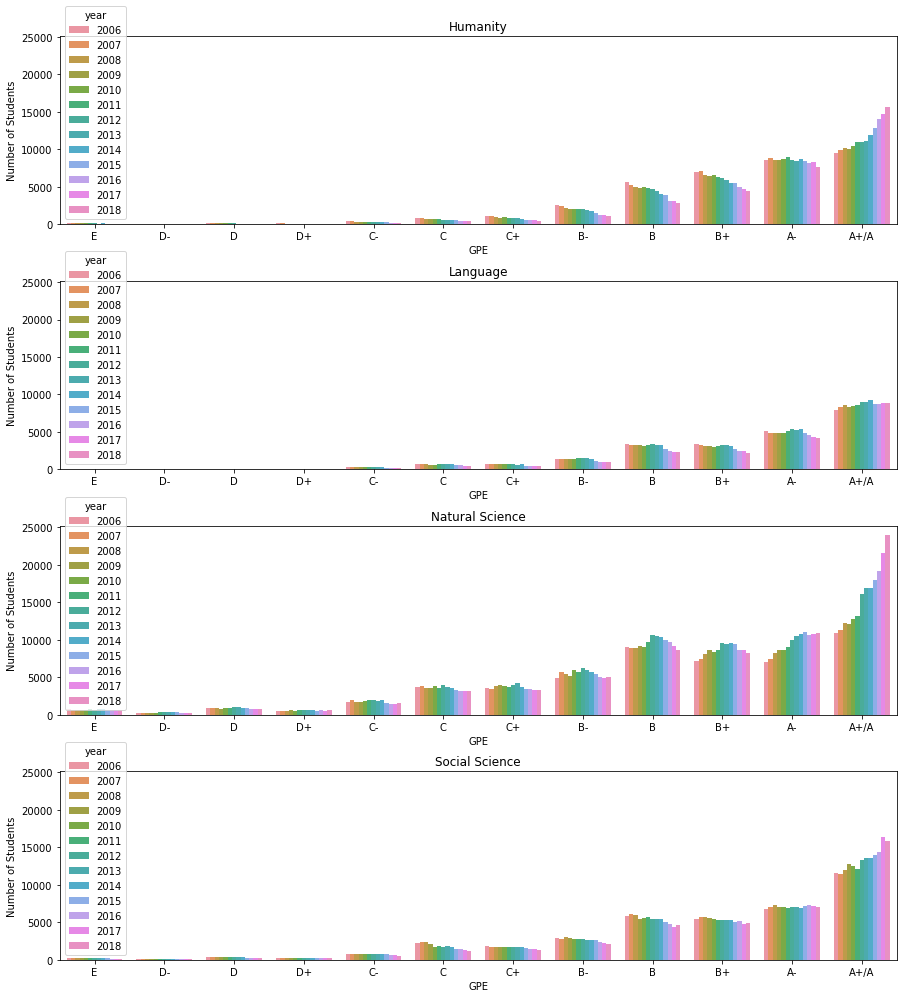

In [55]:
name_lst = ['Humanity', 'Language', 'Natural Science', 'Social Science']
fig, axs = plt.subplots(len(df_lst), figsize=(15,17), sharey=True)
for i, df in enumerate(df_lst):
    df = reset_GPE(df)
    g = sns.countplot(data=df,x='GPE',hue='year', ax=axs[i], order=gpe_lst)
    g.set_title(name_lst[i])
    g.set_ylabel('Number of Students')
    plt.subplots_adjust(hspace = 0.3)

In [49]:
def distplot(df):
    fig, axs = plt.subplots(4,4,figsize=(15,20), sharey=True)
    for i, year in enumerate(years):
        temp = df[df['year']==year]
        g = sns.countplot(temp['GPA'], ax=axs[i//4, i%4], color='olive')
        g.set_title(year)

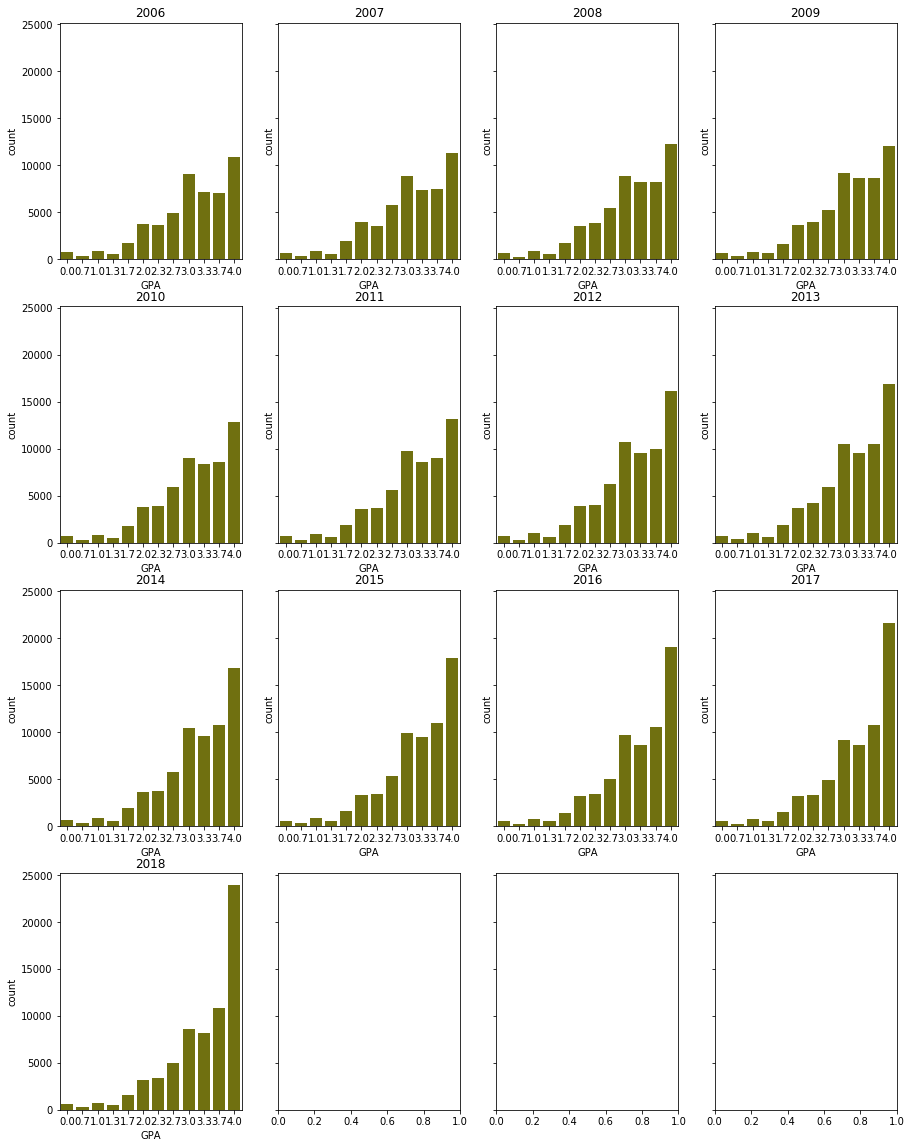

In [57]:
distplot(LSA_NS_df)

## DEBUG

### 100-level DEBUG

In [24]:
df, debug = generate_samples(lv_1)

In [25]:
debug

,year,no_propotion,grad_propotion,no_average,both_average,only_sat_average,only_act_average,size
0,2006,0.025717,0.041667,0.068256,1.098821,0.775275,1.213903,3733
1,2007,0.020937,0.039474,0.056694,0.985675,0.798815,1.337438,3630
2,2008,0.022338,0.023256,0.063065,0.882623,0.758883,1.502545,3850
3,2009,0.018054,0.014925,0.046968,0.740097,0.629049,1.764565,3711
4,2010,0.017588,0.100000,0.051784,0.623241,0.628065,1.880955,3980
5,2011,0.015163,0.293103,0.042954,0.560078,0.613072,2.002824,3825
6,2012,0.020408,0.190476,0.054738,0.531973,0.538144,2.092055,4116
7,2013,0.023071,0.166667,0.063856,0.471354,0.592667,2.090717,3641
8,2014,0.023142,0.322222,0.067318,0.415197,0.606763,2.153073,3889
9,2015,0.026389,0.184211,0.076343,0.390648,0.573981,2.237894,4320


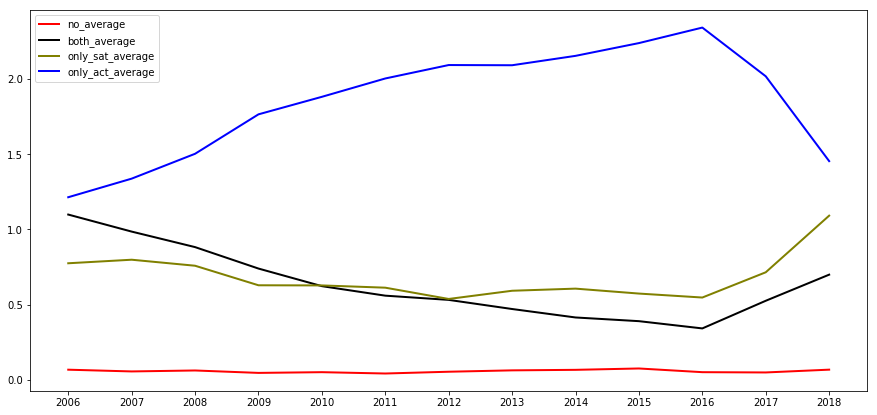

In [26]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot( 'year', 'no_average', data=debug, color='red', linewidth=2)
plt.plot( 'year', 'both_average', data=debug, marker='', color='black', linewidth=2)
plt.plot( 'year', 'only_sat_average', data=debug, marker='', color='olive', linewidth=2)
plt.plot( 'year', 'only_act_average', data=debug, marker='', color='blue', linewidth=2)
plt.legend()

### University-wide DEBUG

In [27]:
df, debug = generate_samples(undergrad_by_term)

In [28]:
debug

,year,no_propotion,grad_propotion,no_average,both_average,only_sat_average,only_act_average,size
0,2006,0.057123,0.350955,0.189547,1.190667,0.771376,1.147115,224515
1,2007,0.056348,0.344801,0.185835,1.167822,0.755403,1.191310,228526
2,2008,0.055658,0.337449,0.185260,1.100900,0.724971,1.298698,231396
3,2009,0.058225,0.334681,0.192875,0.985480,0.661777,1.472160,233592
4,2010,0.060737,0.352441,0.201189,0.852911,0.613418,1.648571,238109
5,2011,0.061767,0.362974,0.204923,0.720130,0.585241,1.811568,244514
6,2012,0.063132,0.348283,0.209837,0.622765,0.583436,1.910824,250412
7,2013,0.062955,0.316553,0.209200,0.557493,0.603797,1.966513,253052
8,2014,0.060416,0.290215,0.200707,0.501971,0.609984,2.033123,252202
9,2015,0.059381,0.292764,0.196552,0.457060,0.595542,2.098874,252520


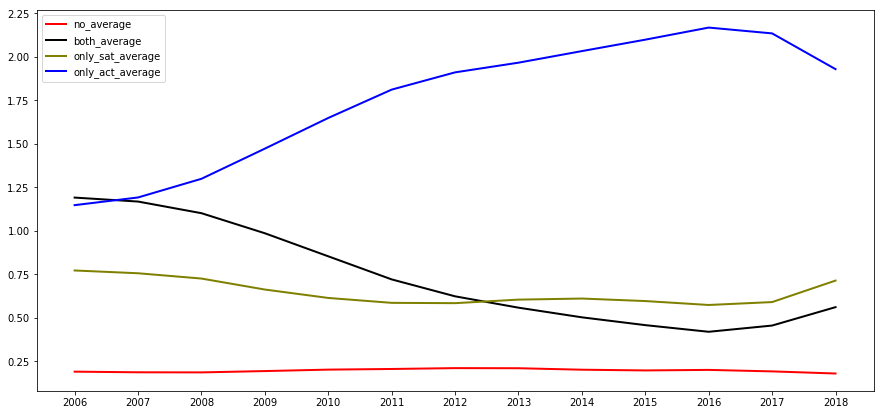

In [29]:
fig, ax = plt.subplots(figsize=(15,7))
plt.plot( 'year', 'no_average', data=debug, color='red', linewidth=2)
plt.plot( 'year', 'both_average', data=debug, marker='', color='black', linewidth=2)
plt.plot( 'year', 'only_sat_average', data=debug, marker='', color='olive', linewidth=2)
plt.plot( 'year', 'only_act_average', data=debug, marker='', color='blue', linewidth=2)
plt.legend()

In [161]:
newdf[(newdf['increase_GPA']>0.1) & (newdf['mean_x']!=0)
     ].sort_values(by="increase_GPA",ascending= False).head(10)

,course,count_x,mean_x,SAT_mean_x,ACT_mean_x,count_y,mean_y,SAT_mean_y,ACT_mean_y,increase_GPA,increase_count,increase_SAT,increase_ACT
209,HARP140,1.0,1.700000,1120.000000,0.000000,1.0,3.700000,1290.000000,27.000000,2.000000,0.0,170.000000,27.000000
114,CLCIV125,18.0,2.000000,764.444444,22.055556,66.0,3.165152,526.060606,20.348485,1.165152,48.0,-238.383838,-1.707071
313,PHYSICS119,15.0,2.953333,330.666667,23.200000,5.0,3.880000,1108.000000,19.400000,0.926667,-10.0,777.333333,-3.800000
412,VOICE111,8.0,3.287500,527.500000,16.250000,7.0,4.000000,652.857143,20.000000,0.712500,-1.0,125.357143,3.750000
290,NAVSCI102,4.0,3.000000,1297.500000,14.750000,16.0,3.693750,591.875000,25.062500,0.693750,12.0,-705.625000,10.312500
342,PSYCH112,170.0,3.002353,840.294118,21.364706,803.0,3.690535,401.930262,23.625156,0.688183,633.0,-438.363856,2.260450
271,MILSCI101,12.0,3.333333,858.333333,23.083333,12.0,4.000000,469.166667,21.750000,0.666667,0.0,-389.166667,-1.333333
260,MATH110,52.0,2.117308,593.269231,18.807692,47.0,2.751064,135.531915,24.638298,0.633756,-5.0,-457.737316,5.830606
350,RELIGION121,10.0,3.130000,348.000000,15.900000,6.0,3.733333,0.000000,28.833333,0.603333,-4.0,-348.000000,12.933333
89,BIOLOGY120,78.0,3.314103,943.205128,20.128205,36.0,3.905556,461.666667,24.888889,0.591453,-42.0,-481.538462,4.760684


In [54]:
len(newdf[(newdf['mean_x']==0) & (newdf['mean_y']!=0)].sort_values(by="increase_count",ascending= False))

188

In [170]:
newdf[(newdf['mean_x']!=0) & (newdf['mean_y']!=0)].sort_values(by="increase_GPA",ascending= True).head(10)

,course,count_x,mean_x,SAT_mean_x,ACT_mean_x,count_y,mean_y,SAT_mean_y,ACT_mean_y,increase_GPA,increase_count,increase_SAT,increase_ACT
40,ASIANLAN103,11.0,3.700000,750.000000,19.272727,2.0,2.500000,690.000000,30.000000,-1.200000,-9.0,-60.000000,10.727273
47,ASIANLAN121,8.0,3.800000,1040.000000,19.625000,3.0,2.800000,483.333333,9.333333,-1.000000,-5.0,-556.666667,-10.291667
354,RUSSIAN103,4.0,3.425000,0.000000,7.250000,6.0,2.733333,475.000000,19.500000,-0.691667,2.0,475.000000,12.250000
170,GEOG111,38.0,3.402632,340.263158,23.157895,12.0,2.725000,214.166667,27.000000,-0.677632,-26.0,-126.096491,3.842105
413,VOICE113,1.0,4.000000,0.000000,29.000000,4.0,3.500000,602.500000,14.750000,-0.500000,3.0,602.500000,-14.250000
288,NAVARCH102,4.0,3.925000,665.000000,23.500000,4.0,3.425000,0.000000,7.250000,-0.500000,0.0,-665.000000,-16.250000
338,PORTUG101,13.0,3.976923,950.769231,17.615385,12.0,3.483333,311.666667,18.583333,-0.493590,-1.0,-639.102564,0.967949
236,JAZZ113,12.0,3.866667,626.666667,17.500000,11.0,3.400000,477.272727,18.545455,-0.466667,-1.0,-149.393939,1.045455
277,MUSICOL122,45.0,3.808889,779.111111,23.288889,40.0,3.382500,547.250000,25.175000,-0.426389,-5.0,-231.861111,1.886111
38,ASIANLAN101,188.0,3.715957,964.840426,13.946809,70.0,3.334286,550.857143,20.085714,-0.381672,-118.0,-413.983283,6.138906


In [168]:
newdf[(newdf['count_x']!=0) & (newdf['count_y']!=0) & (newdf['increase_GPA'] < 0)]['increase_GPA'].mean()

-0.19430782054046195

In [169]:
newdf[(newdf['count_x']!=0) & (newdf['count_y']!=0) & (newdf['increase_GPA'] > 0)]['increase_GPA'].mean()

0.2296461647675669

In [55]:
len(newdf[newdf['count_y']==0].sort_values(by="increase_count",ascending= True))

148

In [166]:
newdf[(newdf['count_y']==0)&(newdf['count_x']!=0)].sort_values(by="increase_count",ascending= True)['mean_x'].mean()

3.512989927147645

In [167]:
newdf[(newdf['count_y']!=0) & (newdf['count_x']==0)].sort_values(by="increase_count",ascending= True)['mean_y'].mean()

3.6068366978102064